In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras.applications import DenseNet121
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,MaxPooling2D , Conv2D,Flatten
from tensorflow.keras.models import Sequential

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report


from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_dir = "../input/ucf-crime-dataset/Train"
test_dir = "../input/ucf-crime-dataset/Test"

SEED = 12
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 64
EPOCHS = 1
LR =  0.00003

In [3]:
crime_types=os.listdir(train_dir)
n=len(crime_types)
print("Number of crime categories : ",n)

Number of crime categories :  14


Crimes have been catogarized in 14 different types.

In [4]:
crimes={}
train=test=0
for clss in crime_types:
    num=len(os.listdir(os.path.join(train_dir,clss)))
    train+=num
    test+=len(os.listdir(os.path.join(test_dir,clss)))
    
    crimes[clss]=num

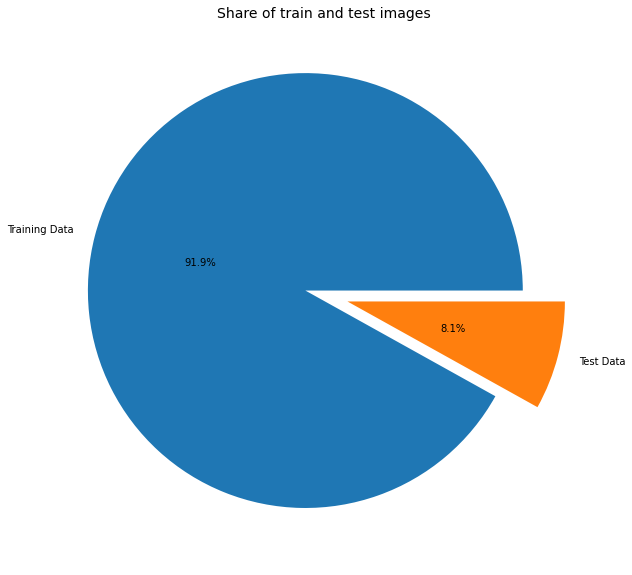

In [5]:
plt.figure(figsize=(15, 10))
plt.pie(x=np.array([train,test]), autopct="%.1f%%", explode=[0.1, 0.1], labels=["Training Data", "Test Data"], pctdistance=0.5)
plt.title("Share of train and test images ", fontsize=14);

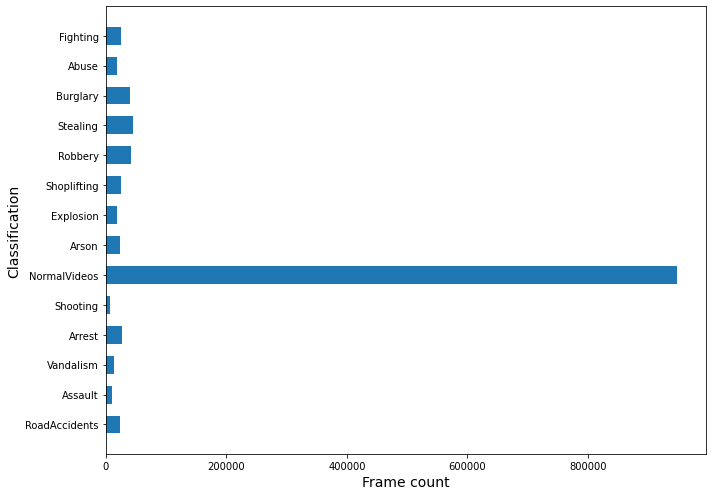

In [6]:
plt.figure(figsize=(10, 7))
plt.barh(list(crimes.keys()), list(crimes.values()), height=0.6, align="center")
plt.yticks(rotation=0)

plt.xlabel("Frame count", fontsize=14)
plt.ylabel("Classification", fontsize=14)
plt.tight_layout()
plt.show()


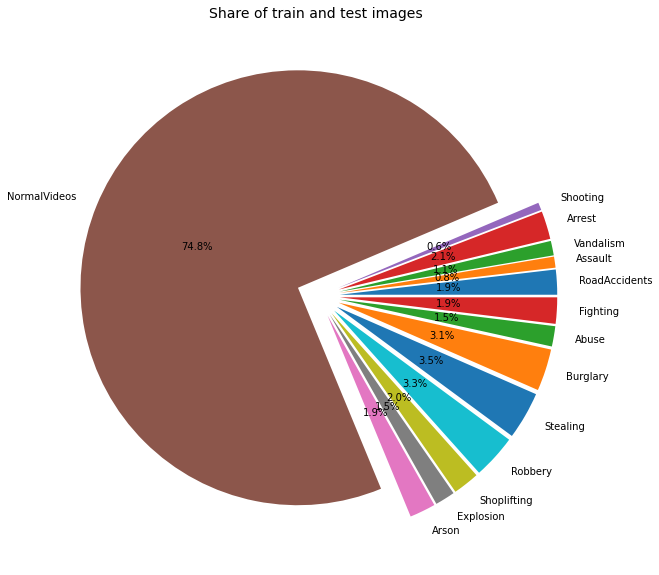

In [7]:
plt.figure(figsize=(15,10))
plt.pie(x=np.array(list(crimes.values())), autopct="%.1f%%", explode=[0.1]*n,labels=list(crimes.keys()), pctdistance=0.5)
plt.title("Share of train and test images ", fontsize=14);

In [8]:
IMG_WIDTH=64
IMG_HEIGHT=64

IMG_SHAPE=(IMG_HEIGHT,IMG_WIDTH)
seed=69

INPUT_SHAPE=(IMG_HEIGHT,IMG_WIDTH,3)

In [ ]:
train_set=image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="training",
)

val_set=image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="validation",
)

test_set=image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    class_names=None,
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=False,
    seed=seed,
)

In [10]:
def transfer_learning():
    base_model=DenseNet121(include_top=False,input_shape=INPUT_SHAPE,weights="imagenet")
    
    thr=149
    for layers in base_model.layers[:thr]:
        layers.trainable=False
    
    for layers in base_model.layers[thr:]:
        layers.trainable=True
    
    return base_model

In [29]:
def create_model():
    model=Sequential()
    
    base_model=transfer_learning()
    model.add(base_model)
    
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.2))
    
    model.add(Dense(n,activation="softmax",name="classification"))
    
    model.summary()
    
    return model
    

In [30]:
model=create_model()

model.compile(optimizer="adam", 
                loss='categorical_crossentropy',
                metrics = [tf.keras.metrics.AUC()])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 2, 2, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               131200    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
classification (Dense)       (None, 14)                1806      
Total params: 7,170,510
Trainable params: 5,586,254
Non-trainable params: 1,584,256
_________________________________________________________________


In [31]:
history = model.fit(x = train_set,validation_data=val_set,epochs = EPOCHS)

15830/15830 [==============================] - 3941s 246ms/step - loss: 0.0698 - auc_3: 0.9989 - val_loss: 0.0168 - val_auc_3: 0.9998


In [33]:
y_true =  np.array([])

for x, y in test_set:
  y_true = np.concatenate([y_true, np.argmax(y.numpy(), axis=-1)])

In [34]:
y_pred=model.predict(test_set)

In [36]:
y_pred

array([[1.0740551e-02, 4.3205997e-05, 6.0920196e-04, ..., 3.0466809e-03,
        2.9543104e-05, 9.7899365e-01],
       [1.4202507e-03, 2.6595732e-04, 1.3631944e-03, ..., 1.9316606e-03,
        2.4334218e-04, 9.6982050e-01],
       [8.6985873e-03, 1.2167515e-03, 2.1693230e-02, ..., 6.6709697e-02,
        7.6579564e-04, 2.6086816e-01],
       ...,
       [9.2367441e-07, 1.8465140e-05, 2.5863055e-04, ..., 1.0745751e-07,
        3.2568346e-07, 1.2153600e-06],
       [6.2368167e-07, 1.6163756e-05, 9.3281436e-05, ..., 5.3182453e-07,
        5.9164159e-07, 7.7632728e-07],
       [3.2719158e-06, 3.1915089e-05, 3.1186827e-04, ..., 3.6825415e-07,
        1.2698306e-06, 6.5039103e-06]], dtype=float32)

In [38]:
y_true

array([ 0.,  0.,  0., ..., 13., 13., 13.])

In [39]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(crime_types):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

ROC AUC score: 0.8226687179192366


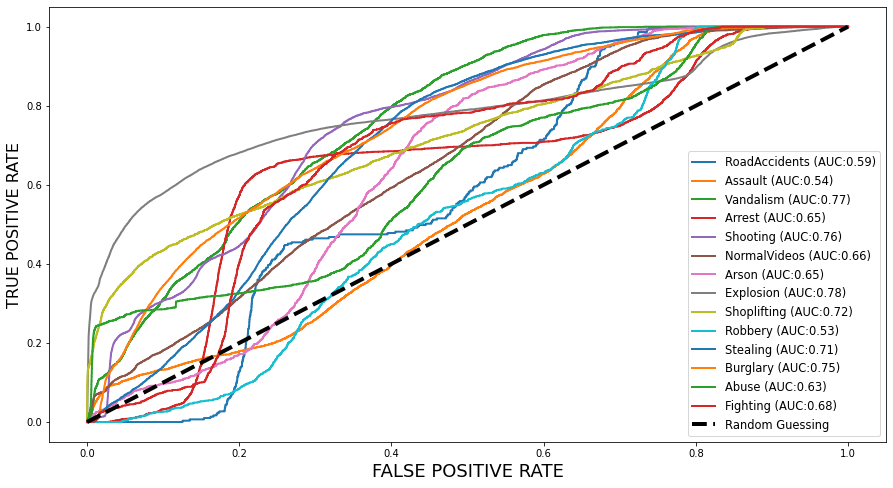

In [40]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))


print('ROC AUC score:', multiclass_roc_auc_score(y_true , y_pred  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [44]:
model.save("/kaggle/working/")